In [1]:
!pip install dtreeviz
!pip install keras-tuner --upgrade
!pip install tensorflow

# Importacion de datos

In [2]:
from IPython.display import display
import seaborn as sns
import dtreeviz.trees as dtreeviz
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

np.random.seed(1)
tf.random.set_seed(1)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.filterwarnings('always')

In [3]:
ds_hotels = pd.read_csv("./hotels_modificado_train.csv")
ds_h = ds_hotels.copy()

In [4]:
def agent_a_string(value):
    return str(value)
ds_h["agent"] = ds_h["agent"].apply(agent_a_string)

In [5]:
ds = ds_h.drop(["id"], axis="columns", inplace=False)

In [6]:
ds.agent.value_counts()

agent
9.0      21296
240.0     7022
14.0      1613
7.0       1517
250.0     1314
         ...  
449.0        1
247.0        1
269.0        1
301.0        1
25.0         1
Name: count, Length: 296, dtype: int64

In [7]:
#One hot encoding para variables categoricas
var_cual = ["hotel", "arrival_date_month", "meal", "country", "market_segment", 
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "agent", 
"customer_type"]
ds = pd.get_dummies(ds, columns=var_cual, drop_first=True)
# Convert True/False to 1/0 in encoded columns
ds = ds.astype(int)
ds.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,agent_92.0,agent_93.0,agent_94.0,agent_95.0,agent_96.0,agent_98.0,agent_99.0,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,49,2016,37,5,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4,2015,44,31,0,1,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,25,2016,42,13,0,1,2,2,0,0,...,0,0,0,0,0,0,0,0,1,0
3,26,2016,51,12,2,5,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,104,2017,12,19,2,5,2,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Hacemos un split del dataset

In [8]:
#Creo un dataset con los features que voy a usar para clasificar
ds_x=ds.drop(['is_canceled'], axis='columns', inplace=False)

#Creo un dataset con la variable target
ds_y = ds['is_canceled'].copy()

#Genero los conjuntos de train y de test
x_train, x_test, y_train, y_test = train_test_split(ds_x,
                                                    ds_y, 
                                                    test_size=0.25,  #proporcion 70/30
                                                    random_state=4, #semilla
                                                    stratify=ds["is_canceled"].values) 

Funciones que nos seran utiles

In [9]:
def plot_regression(modelo,x,y,title="",xlabel="x",ylabel="y"):
    plt.figure()
    
    plt.plot(x,y,"o",label="Valores verdaderos")
    plt.plot(x,modelo.predict(x),"x",label="Valores estimados")
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Modelo de red neuronal con keras

In [10]:
d_in=len(x_train.columns)

modelo = keras.Sequential()   
modelo.add(keras.layers.Dense(1852, input_shape=(d_in,), activation='relu'))
modelo.add(keras.layers.Dense(1, activation='sigmoid'))

modelo.compile(
  optimizer= 'adam', 
  loss='binary_crossentropy',
  metrics=['accuracy','Precision','Recall'])

modelo_history = modelo.fit(x_train,y_train,epochs=525,batch_size=410,verbose=False,validation_data=(x_test,y_test))

Es un modelo muy lento, tarda 25min. Es debido a la mucha cantidad de epocas y neuranas utilizadas

351/351 [==============================] - 1s 2ms/step - loss: 0.4000 - accuracy: 0.8140 - precision: 0.7370 - recall: 0.8076
Perdida: 0.3999634385108948
Acurracy: 0.8140363097190857
Precision: 0.737030029296875
Recall: 0.8075949549674988
351/351 [==============================] - 1s 2ms/step
f1_score: 0.7707006369426751


c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:219: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


Text(50.722222222222214, 0.5, 'True')

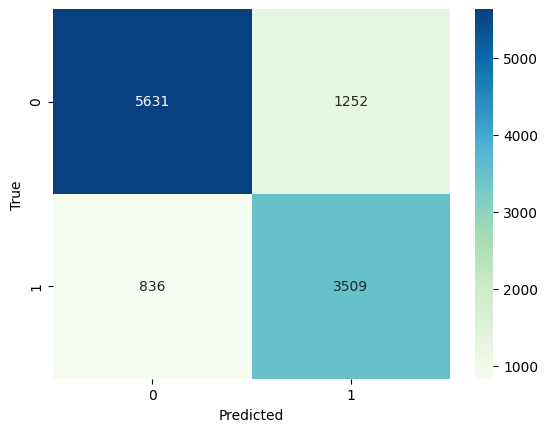

In [33]:
loss, accuracy, precision, recall = modelo.evaluate(x_test,y_test)
print(f"Perdida: {loss}")
print(f"Acurracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

y_pred = modelo.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(f"f1_score: {f1_score(y_test,y_pred)}")

tabla = confusion_matrix(y_test,y_pred)
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# Busqueda de mejor arquitectura y mejores hiperparametros

Los datos estan desbalanceados. Hacemos un balanceo aplicando un muestreo aleatorio de la clase mayoritaria y minoritaria

In [11]:
y_train.value_counts(normalize=True)

is_canceled
0    0.612962
1    0.387038
Name: proportion, dtype: float64

In [12]:
datos_train = pd.concat([x_train,y_train],axis=1)
clase_mayoritaria = datos_train[datos_train['is_canceled'] == 0]
clase_minoritaria = datos_train[datos_train['is_canceled'] == 1]

submuetreo_mayoritario = clase_mayoritaria.sample(n=len(clase_minoritaria), random_state=42)
train_balanceado = pd.concat([submuetreo_mayoritario, clase_minoritaria])
train_balanceado = train_balanceado.sample(frac=1, random_state=42).reset_index(drop=True)

x_train_balanceado = train_balanceado.drop('is_canceled',axis=1)
y_train_balanceado = train_balanceado['is_canceled']
y_train_balanceado.value_counts(normalize=True)

is_canceled
0    0.5
1    0.5
Name: proportion, dtype: float64

In [13]:
x_train_balanceado

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,agent_92.0,agent_93.0,agent_94.0,agent_95.0,agent_96.0,agent_98.0,agent_99.0,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,1,2017,32,11,0,1,2,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,2,2017,13,31,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,118,2016,24,6,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5,2015,37,10,0,2,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,107,2016,32,2,0,5,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26069,111,2017,17,27,1,3,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
26070,30,2017,26,26,1,2,2,0,0,0,...,0,0,0,0,0,0,0,0,1,0
26071,157,2016,29,14,0,2,2,1,0,0,...,0,0,0,0,0,0,0,0,0,1
26072,157,2017,30,26,2,8,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0


### Primero armamos el RN sin los mejores Hiperparametros

In [14]:
from sklearn.utils import class_weight
from keras.optimizers import Adam

d_in=len(x_train.columns)
modelo = keras.Sequential()
modelo.add(keras.layers.Dense(94, input_shape=(d_in,), activation='relu'))#+1
modelo.add(keras.layers.Dense(88, activation='relu'))#+1
modelo.add(keras.layers.Dense(79, activation='relu'))#+3
modelo.add(keras.layers.Dropout(0.36))    
modelo.add(keras.layers.Dense(1, activation='sigmoid'))

modelo.compile(
  optimizer= Adam(learning_rate=0.001), 
  loss='binary_crossentropy',
  metrics=['accuracy','Precision','Recall'])

modelo_history = modelo.fit(x_train_balanceado,y_train_balanceado,
                            epochs=257,
                            batch_size=117,
                            verbose=False,
                            validation_data=(x_test,y_test),
                            class_weight={0:0.5, 1: 0.5})

351/351 [==============================] - 0s 974us/step - loss: 0.4147 - accuracy: 0.8098 - precision: 0.7228 - recall: 0.8246
Perdida: 0.4146758019924164
Acurracy: 0.8097612857818604
Precision: 0.7228162288665771
Recall: 0.8246260285377502
351/351 [==============================] - 0s 758us/step
f1_score: 0.7703719630187057


c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:219: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


Text(50.722222222222214, 0.5, 'True')

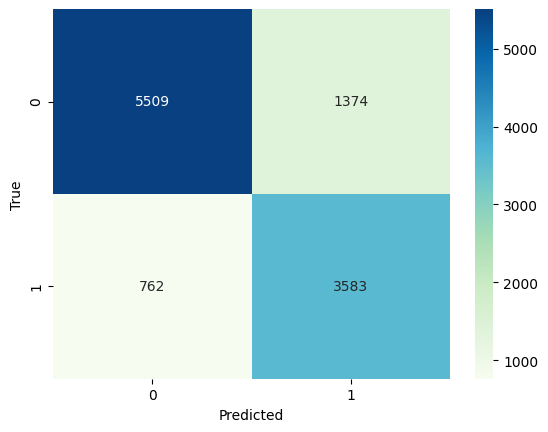

In [56]:
loss, accuracy, precision, recall = modelo.evaluate(x_test,y_test)
print(f"Perdida: {loss}")
print(f"Acurracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

y_pred = modelo.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(f"f1_score: {f1_score(y_test,y_pred)}")

tabla = confusion_matrix(y_test,y_pred)
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

Como podemos ver esta Red Neuronal es mucho mejor que la anterior

### Ahora buscamos los mejores Hiperparametros con GridSearchCV

Ahora buscamos sus mejores hiperparametros con GridSearchCV 

In [42]:
from sklearn.utils import class_weight
from keras.optimizers import Adam

def create_model():
    d_in = len(x_train.columns)
    modelo = keras.Sequential()
    modelo.add(keras.layers.Dense(94, input_shape=(d_in,), activation='relu'))#+1
    modelo.add(keras.layers.Dense(88, activation='relu'))#+1
    modelo.add(keras.layers.Dense(79, activation='relu'))#+3
    modelo.add(keras.layers.Dropout(0.36))    
    modelo.add(keras.layers.Dense(1, activation='sigmoid'))

    modelo.compile(
        optimizer=Adam(learning_rate=0.001), 
        loss='binary_crossentropy',
        metrics=['accuracy','Precision','Recall'])
    
    return modelo

In [43]:
from keras.wrappers.scikit_learn import KerasClassifier 
modelo_cv = KerasClassifier(build_fn=create_model)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_708\4058877753.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


In [44]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'epochs': [100, 200, 250],
    'batch_size': [50, 100, 120]
}

grid = GridSearchCV(estimator=modelo_cv, param_grid=param_grid)
grid_result = grid.fit(x_train_balanceado, y_train_balanceado)

Epoch 1/100


c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.2274 - accuracy: 0.5560 - precision: 0.5502 - recall: 0.6121
Epoch 2/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6729 - accuracy: 0.5855 - precision: 0.5856 - recall: 0.5842
Epoch 3/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6695 - accuracy: 0.5973 - precision: 0.5938 - recall: 0.6157
Epoch 4/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6652 - accuracy: 0.6054 - precision: 0.6076 - recall: 0.5944
Epoch 5/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6545 - accuracy: 0.6213 - precision: 0.6186 - recall: 0.6322
Epoch 6/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6394 - accuracy: 0.6440 - precision: 0.6413 - recall: 0.6533
Epoch 7/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6186 - accuracy: 0.6690 - precision: 0.6738 - recall: 0.6548
Epoch 8/100
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.5098 - accuracy: 0.5755 - precision: 0.5702 - recall: 0.6071
Epoch 2/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6671 - accuracy: 0.5967 - precision: 0.5930 - recall: 0.6123
Epoch 3/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6579 - accuracy: 0.6127 - precision: 0.5996 - recall: 0.6745
Epoch 4/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6515 - accuracy: 0.6204 - precision: 0.6073 - recall: 0.6773
Epoch 5/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6388 - accuracy: 0.6326 - precision: 0.6114 - recall: 0.7240
Epoch 6/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6259 - accuracy: 0.6422 - precision: 0.6257 - recall: 0.7048
Epoch 7/100
418/418 [==============================] - 0s 1ms/step - loss: 0.5949 - accuracy: 0.6863 - precision: 0.6795 - recall: 0.7030
Epoch 8/100
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.0445 - accuracy: 0.5711 - precision: 0.5740 - recall: 0.5677
Epoch 2/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6726 - accuracy: 0.5780 - precision: 0.5683 - recall: 0.6664
Epoch 3/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6722 - accuracy: 0.5736 - precision: 0.5758 - recall: 0.5751
Epoch 4/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6636 - accuracy: 0.5931 - precision: 0.5867 - recall: 0.6435
Epoch 5/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6614 - accuracy: 0.5961 - precision: 0.5875 - recall: 0.6590
Epoch 6/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6445 - accuracy: 0.6179 - precision: 0.6106 - recall: 0.6611
Epoch 7/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6359 - accuracy: 0.6336 - precision: 0.6367 - recall: 0.6306
Epoch 8/100
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.4525 - accuracy: 0.5611 - precision: 0.5602 - recall: 0.5726
Epoch 2/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6707 - accuracy: 0.5882 - precision: 0.5853 - recall: 0.6079
Epoch 3/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6654 - accuracy: 0.5880 - precision: 0.5888 - recall: 0.5867
Epoch 4/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6627 - accuracy: 0.6018 - precision: 0.6009 - recall: 0.6088
Epoch 5/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6560 - accuracy: 0.6099 - precision: 0.6091 - recall: 0.6156
Epoch 6/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6428 - accuracy: 0.6143 - precision: 0.6266 - recall: 0.5674
Epoch 7/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6171 - accuracy: 0.6453 - precision: 0.6355 - recall: 0.6831
Epoch 8/100
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.1571 - accuracy: 0.5637 - precision: 0.5653 - recall: 0.5362
Epoch 2/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6808 - accuracy: 0.5575 - precision: 0.5541 - recall: 0.5711
Epoch 3/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6703 - accuracy: 0.5756 - precision: 0.5561 - recall: 0.7326
Epoch 4/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6630 - accuracy: 0.5986 - precision: 0.5832 - recall: 0.6801
Epoch 5/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6655 - accuracy: 0.6081 - precision: 0.6054 - recall: 0.6120
Epoch 6/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6548 - accuracy: 0.6217 - precision: 0.6292 - recall: 0.5855
Epoch 7/100
418/418 [==============================] - 0s 1ms/step - loss: 0.6633 - accuracy: 0.6026 - precision: 0.6259 - recall: 0.5021
Epoch 8/100
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.3369 - accuracy: 0.5581 - precision: 0.5533 - recall: 0.6026
Epoch 2/200
418/418 [==============================] - 0s 1ms/step - loss: 0.6730 - accuracy: 0.5771 - precision: 0.5659 - recall: 0.6611
Epoch 3/200
418/418 [==============================] - 0s 1ms/step - loss: 0.6644 - accuracy: 0.5938 - precision: 0.5845 - recall: 0.6487
Epoch 4/200
418/418 [==============================] - 0s 1ms/step - loss: 0.6622 - accuracy: 0.6074 - precision: 0.6002 - recall: 0.6427
Epoch 5/200
418/418 [==============================] - 0s 1ms/step - loss: 0.6541 - accuracy: 0.6238 - precision: 0.6254 - recall: 0.6169
Epoch 6/200
418/418 [==============================] - 0s 1ms/step - loss: 0.6399 - accuracy: 0.6493 - precision: 0.6584 - recall: 0.6203
Epoch 7/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6246 - accuracy: 0.6459 - precision: 0.6810 - recall: 0.5484
Epoch 8/200
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


Epoch 1/200
418/418 [==============================] - 1s 1ms/step - loss: 1.3497 - accuracy: 0.5377 - precision: 0.5473 - recall: 0.4270
Epoch 2/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6741 - accuracy: 0.5635 - precision: 0.5599 - recall: 0.5866
Epoch 3/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6804 - accuracy: 0.5575 - precision: 0.5607 - recall: 0.5239
Epoch 4/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6790 - accuracy: 0.5666 - precision: 0.5948 - recall: 0.4132
Epoch 5/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6680 - accuracy: 0.5777 - precision: 0.6050 - recall: 0.4435
Epoch 6/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6697 - accuracy: 0.5774 - precision: 0.6072 - recall: 0.4343
Epoch 7/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6791 - accuracy: 0.5641 - precision: 0.6213 - recall: 0.3243
Epoch 8/200
418/418 [=============

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.5128 - accuracy: 0.5553 - precision: 0.5629 - recall: 0.5143
Epoch 2/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6729 - accuracy: 0.5773 - precision: 0.5757 - recall: 0.6034
Epoch 3/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6666 - accuracy: 0.5839 - precision: 0.5685 - recall: 0.7133
Epoch 4/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6659 - accuracy: 0.5880 - precision: 0.5750 - recall: 0.6903
Epoch 5/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6679 - accuracy: 0.5920 - precision: 0.5954 - recall: 0.5863
Epoch 6/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6485 - accuracy: 0.6086 - precision: 0.6248 - recall: 0.5530
Epoch 7/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6490 - accuracy: 0.6064 - precision: 0.6011 - recall: 0.6442
Epoch 8/200
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.1633 - accuracy: 0.5622 - precision: 0.5575 - recall: 0.6075
Epoch 2/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6695 - accuracy: 0.5823 - precision: 0.5712 - recall: 0.6635
Epoch 3/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6687 - accuracy: 0.5820 - precision: 0.5679 - recall: 0.6892
Epoch 4/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6650 - accuracy: 0.6011 - precision: 0.5944 - recall: 0.6388
Epoch 5/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6601 - accuracy: 0.6135 - precision: 0.6020 - recall: 0.6723
Epoch 6/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6492 - accuracy: 0.6263 - precision: 0.6170 - recall: 0.6684
Epoch 7/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6240 - accuracy: 0.6502 - precision: 0.6470 - recall: 0.6626
Epoch 8/200
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.0612 - accuracy: 0.5735 - precision: 0.5649 - recall: 0.6259
Epoch 2/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6658 - accuracy: 0.5983 - precision: 0.5874 - recall: 0.6499
Epoch 3/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6700 - accuracy: 0.6036 - precision: 0.5950 - recall: 0.6392
Epoch 4/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6539 - accuracy: 0.6177 - precision: 0.6067 - recall: 0.6610
Epoch 5/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6511 - accuracy: 0.6165 - precision: 0.6142 - recall: 0.6183
Epoch 6/200
418/418 [==============================] - 1s 1ms/step - loss: 0.6286 - accuracy: 0.6510 - precision: 0.6462 - recall: 0.6610
Epoch 7/200
418/418 [==============================] - 1s 1ms/step - loss: 0.5808 - accuracy: 0.7031 - precision: 0.7007 - recall: 0.7050
Epoch 8/200
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.5103 - accuracy: 0.5645 - precision: 0.5633 - recall: 0.5729
Epoch 2/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6755 - accuracy: 0.5799 - precision: 0.5778 - recall: 0.5927
Epoch 3/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6710 - accuracy: 0.5807 - precision: 0.5737 - recall: 0.6277
Epoch 4/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6719 - accuracy: 0.5857 - precision: 0.5897 - recall: 0.5630
Epoch 5/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6733 - accuracy: 0.5926 - precision: 0.6079 - recall: 0.5215
Epoch 6/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6519 - accuracy: 0.6159 - precision: 0.6147 - recall: 0.6205
Epoch 7/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6476 - accuracy: 0.6248 - precision: 0.6377 - recall: 0.5774
Epoch 8/250
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.2742 - accuracy: 0.5677 - precision: 0.5647 - recall: 0.5837
Epoch 2/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6719 - accuracy: 0.5868 - precision: 0.5812 - recall: 0.6161
Epoch 3/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6628 - accuracy: 0.6036 - precision: 0.5922 - recall: 0.6609
Epoch 4/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6568 - accuracy: 0.6095 - precision: 0.6001 - recall: 0.6523
Epoch 5/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6374 - accuracy: 0.6394 - precision: 0.6245 - recall: 0.6960
Epoch 6/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6173 - accuracy: 0.6630 - precision: 0.6578 - recall: 0.6770
Epoch 7/250
418/418 [==============================] - 0s 1ms/step - loss: 0.5797 - accuracy: 0.7068 - precision: 0.7051 - recall: 0.7092
Epoch 8/250
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.2719 - accuracy: 0.5479 - precision: 0.5534 - recall: 0.5188
Epoch 2/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6731 - accuracy: 0.5791 - precision: 0.5818 - recall: 0.5769
Epoch 3/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6686 - accuracy: 0.5851 - precision: 0.5822 - recall: 0.6174
Epoch 4/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6569 - accuracy: 0.6054 - precision: 0.5953 - recall: 0.6709
Epoch 5/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6510 - accuracy: 0.6137 - precision: 0.6127 - recall: 0.6285
Epoch 6/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6264 - accuracy: 0.6458 - precision: 0.6417 - recall: 0.6682
Epoch 7/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6286 - accuracy: 0.6314 - precision: 0.6231 - recall: 0.6746
Epoch 8/250
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 995us/step - loss: 1.0845 - accuracy: 0.5678 - precision: 0.5715 - recall: 0.5450
Epoch 2/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6685 - accuracy: 0.5878 - precision: 0.5937 - recall: 0.5587
Epoch 3/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6655 - accuracy: 0.5934 - precision: 0.5796 - recall: 0.6832
Epoch 4/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6646 - accuracy: 0.5973 - precision: 0.5787 - recall: 0.7187
Epoch 5/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6528 - accuracy: 0.6194 - precision: 0.5971 - recall: 0.7369
Epoch 6/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6415 - accuracy: 0.6360 - precision: 0.6131 - recall: 0.7389
Epoch 7/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6212 - accuracy: 0.6597 - precision: 0.6411 - recall: 0.7272
Epoch 8/250
418/418 [=======================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


418/418 [==============================] - 1s 1ms/step - loss: 1.1460 - accuracy: 0.5676 - precision: 0.5638 - recall: 0.5826
Epoch 2/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6710 - accuracy: 0.5874 - precision: 0.5753 - recall: 0.6556
Epoch 3/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6647 - accuracy: 0.6013 - precision: 0.5909 - recall: 0.6487
Epoch 4/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6578 - accuracy: 0.6059 - precision: 0.5972 - recall: 0.6414
Epoch 5/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6566 - accuracy: 0.6176 - precision: 0.6132 - recall: 0.6287
Epoch 6/250
418/418 [==============================] - 1s 1ms/step - loss: 0.6381 - accuracy: 0.6309 - precision: 0.6300 - recall: 0.6271
Epoch 7/250
418/418 [==============================] - 0s 1ms/step - loss: 0.6332 - accuracy: 0.6026 - precision: 0.6597 - recall: 0.4176
Epoch 8/250
418/418 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 1ms/step - loss: 2.3495 - accuracy: 0.5629 - precision: 0.5599 - recall: 0.5868
Epoch 2/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6671 - accuracy: 0.5919 - precision: 0.5787 - recall: 0.6747
Epoch 3/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6670 - accuracy: 0.5943 - precision: 0.5923 - recall: 0.6042
Epoch 4/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6618 - accuracy: 0.5989 - precision: 0.5981 - recall: 0.6021
Epoch 5/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6533 - accuracy: 0.6154 - precision: 0.6080 - recall: 0.6491
Epoch 6/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6487 - accuracy: 0.6221 - precision: 0.6211 - recall: 0.6260
Epoch 7/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6247 - accuracy: 0.6536 - precision: 0.6541 - recall: 0.6514
Epoch 8/100
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 1ms/step - loss: 1.3135 - accuracy: 0.5553 - precision: 0.5566 - recall: 0.5368
Epoch 2/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6821 - accuracy: 0.5499 - precision: 0.5442 - recall: 0.6040
Epoch 3/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6795 - accuracy: 0.5710 - precision: 0.5581 - recall: 0.6742
Epoch 4/100
209/209 [==============================] - 0s 1ms/step - loss: 0.6821 - accuracy: 0.5663 - precision: 0.5883 - recall: 0.4367
Epoch 5/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6766 - accuracy: 0.5818 - precision: 0.6038 - recall: 0.4713
Epoch 6/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6696 - accuracy: 0.5989 - precision: 0.6183 - recall: 0.5132
Epoch 7/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6808 - accuracy: 0.5600 - precision: 0.6150 - recall: 0.3164
Epoch 8/100
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 3.5948 - accuracy: 0.5625 - precision: 0.5604 - recall: 0.6000
Epoch 2/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.5949 - precision: 0.5890 - recall: 0.6414
Epoch 3/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6636 - accuracy: 0.5975 - precision: 0.6001 - recall: 0.5964
Epoch 4/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6586 - accuracy: 0.6091 - precision: 0.5997 - recall: 0.6676
Epoch 5/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6576 - accuracy: 0.6097 - precision: 0.5944 - recall: 0.7028
Epoch 6/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6545 - accuracy: 0.6114 - precision: 0.6100 - recall: 0.6284
Epoch 7/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6386 - accuracy: 0.6256 - precision: 0.6195 - recall: 0.6609
Epoch 8/100
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.9237 - accuracy: 0.5689 - precision: 0.5653 - recall: 0.6006
Epoch 2/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6677 - accuracy: 0.5895 - precision: 0.5739 - recall: 0.6985
Epoch 3/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.5941 - precision: 0.5775 - recall: 0.7040
Epoch 4/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6617 - accuracy: 0.5979 - precision: 0.5770 - recall: 0.7364
Epoch 5/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6625 - accuracy: 0.5895 - precision: 0.5699 - recall: 0.7330
Epoch 6/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6595 - accuracy: 0.6015 - precision: 0.5961 - recall: 0.6319
Epoch 7/100
209/209 [==============================] - 1s 2ms/step - loss: 0.6541 - accuracy: 0.5985 - precision: 0.6020 - recall: 0.5838
Epoch 8/100
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.4987 - accuracy: 0.5681 - precision: 0.5605 - recall: 0.6151
Epoch 2/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6653 - accuracy: 0.5960 - precision: 0.5825 - recall: 0.6663
Epoch 3/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6650 - accuracy: 0.5953 - precision: 0.5782 - recall: 0.6928
Epoch 4/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6557 - accuracy: 0.6115 - precision: 0.5949 - recall: 0.6895
Epoch 5/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6574 - accuracy: 0.6045 - precision: 0.5869 - recall: 0.6949
Epoch 6/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6439 - accuracy: 0.6295 - precision: 0.6122 - recall: 0.6986
Epoch 7/100
209/209 [==============================] - 0s 2ms/step - loss: 0.6176 - accuracy: 0.6570 - precision: 0.6390 - recall: 0.7159
Epoch 8/100
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.9673 - accuracy: 0.5489 - precision: 0.5597 - recall: 0.4577
Epoch 2/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.5870 - precision: 0.5875 - recall: 0.5839
Epoch 3/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.5989 - precision: 0.5887 - recall: 0.6561
Epoch 4/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6613 - accuracy: 0.6041 - precision: 0.5881 - recall: 0.6945
Epoch 5/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6624 - accuracy: 0.6013 - precision: 0.5774 - recall: 0.7550
Epoch 6/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6582 - accuracy: 0.6094 - precision: 0.5856 - recall: 0.7474
Epoch 7/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6504 - accuracy: 0.6201 - precision: 0.5922 - recall: 0.7704
Epoch 8/200
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.6208 - accuracy: 0.5608 - precision: 0.5563 - recall: 0.5936
Epoch 2/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6702 - accuracy: 0.5894 - precision: 0.5775 - recall: 0.6606
Epoch 3/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6669 - accuracy: 0.5855 - precision: 0.5818 - recall: 0.6023
Epoch 4/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6622 - accuracy: 0.5981 - precision: 0.5869 - recall: 0.6574
Epoch 5/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6569 - accuracy: 0.6078 - precision: 0.5990 - recall: 0.6484
Epoch 6/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.6113 - precision: 0.6108 - recall: 0.6099
Epoch 7/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6484 - accuracy: 0.6154 - precision: 0.6033 - recall: 0.6703
Epoch 8/200
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.8092 - accuracy: 0.5448 - precision: 0.5435 - recall: 0.5882
Epoch 2/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.5803 - precision: 0.5694 - recall: 0.6753
Epoch 3/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6709 - accuracy: 0.5823 - precision: 0.5820 - recall: 0.5983
Epoch 4/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6585 - accuracy: 0.6036 - precision: 0.5883 - recall: 0.7031
Epoch 5/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6574 - accuracy: 0.6064 - precision: 0.6000 - recall: 0.6500
Epoch 6/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6451 - accuracy: 0.6282 - precision: 0.6159 - recall: 0.6908
Epoch 7/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6256 - accuracy: 0.6496 - precision: 0.6380 - recall: 0.6992
Epoch 8/200
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.5962 - accuracy: 0.5754 - precision: 0.5724 - recall: 0.5992
Epoch 2/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6639 - accuracy: 0.5990 - precision: 0.5849 - recall: 0.6845
Epoch 3/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6673 - accuracy: 0.5901 - precision: 0.5767 - recall: 0.6806
Epoch 4/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6571 - accuracy: 0.6064 - precision: 0.5862 - recall: 0.7261
Epoch 5/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6520 - accuracy: 0.6181 - precision: 0.5952 - recall: 0.7411
Epoch 6/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6429 - accuracy: 0.6259 - precision: 0.5954 - recall: 0.7883
Epoch 7/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6409 - accuracy: 0.6310 - precision: 0.6012 - recall: 0.7799
Epoch 8/200
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.8447 - accuracy: 0.5627 - precision: 0.5593 - recall: 0.5745
Epoch 2/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6724 - accuracy: 0.5803 - precision: 0.5672 - recall: 0.6637
Epoch 3/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6646 - accuracy: 0.5924 - precision: 0.5735 - recall: 0.7086
Epoch 4/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6610 - accuracy: 0.5949 - precision: 0.5723 - recall: 0.7383
Epoch 5/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6699 - accuracy: 0.5974 - precision: 0.5864 - recall: 0.6498
Epoch 6/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6563 - accuracy: 0.6079 - precision: 0.6059 - recall: 0.6082
Epoch 7/200
209/209 [==============================] - 0s 2ms/step - loss: 0.6561 - accuracy: 0.6155 - precision: 0.6032 - recall: 0.6662
Epoch 8/200
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 2.5709 - accuracy: 0.5448 - precision: 0.5432 - recall: 0.5620
Epoch 2/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6676 - accuracy: 0.5911 - precision: 0.5779 - recall: 0.6746
Epoch 3/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.6063 - precision: 0.5900 - recall: 0.6966
Epoch 4/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6533 - accuracy: 0.6132 - precision: 0.5969 - recall: 0.6967
Epoch 5/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6507 - accuracy: 0.6187 - precision: 0.6043 - recall: 0.6875
Epoch 6/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 0.6196 - precision: 0.6018 - recall: 0.7065
Epoch 7/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6380 - accuracy: 0.6347 - precision: 0.6119 - recall: 0.7361
Epoch 8/250
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 2.5011 - accuracy: 0.5620 - precision: 0.5594 - recall: 0.5769
Epoch 2/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6618 - accuracy: 0.5995 - precision: 0.5949 - recall: 0.6193
Epoch 3/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6524 - accuracy: 0.6198 - precision: 0.6052 - recall: 0.6854
Epoch 4/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6487 - accuracy: 0.6206 - precision: 0.6050 - recall: 0.6908
Epoch 5/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6297 - accuracy: 0.6456 - precision: 0.6328 - recall: 0.6908
Epoch 6/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6120 - accuracy: 0.6630 - precision: 0.6576 - recall: 0.6777
Epoch 7/250
209/209 [==============================] - 0s 2ms/step - loss: 0.5968 - accuracy: 0.6800 - precision: 0.6774 - recall: 0.6852
Epoch 8/250
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 1ms/step - loss: 1.3536 - accuracy: 0.5589 - precision: 0.5581 - recall: 0.5868
Epoch 2/250
209/209 [==============================] - 0s 1ms/step - loss: 0.6682 - accuracy: 0.5972 - precision: 0.5889 - recall: 0.6571
Epoch 3/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.5956 - precision: 0.5754 - recall: 0.7453
Epoch 4/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6589 - accuracy: 0.6051 - precision: 0.5794 - recall: 0.7813
Epoch 5/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6641 - accuracy: 0.5868 - precision: 0.5623 - recall: 0.8022
Epoch 6/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6521 - accuracy: 0.5974 - precision: 0.5684 - recall: 0.8255
Epoch 7/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6499 - accuracy: 0.5996 - precision: 0.5745 - recall: 0.7837
Epoch 8/250
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 2ms/step - loss: 1.9617 - accuracy: 0.5555 - precision: 0.5555 - recall: 0.5602
Epoch 2/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6685 - accuracy: 0.5863 - precision: 0.5682 - recall: 0.7228
Epoch 3/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6658 - accuracy: 0.5865 - precision: 0.5654 - recall: 0.7515
Epoch 4/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6668 - accuracy: 0.5924 - precision: 0.5761 - recall: 0.7030
Epoch 5/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6619 - accuracy: 0.5973 - precision: 0.5869 - recall: 0.6601
Epoch 6/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6577 - accuracy: 0.6097 - precision: 0.5877 - recall: 0.7380
Epoch 7/250
209/209 [==============================] - 0s 2ms/step - loss: 0.6549 - accuracy: 0.6131 - precision: 0.5965 - recall: 0.7014
Epoch 8/250
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


209/209 [==============================] - 1s 3ms/step - loss: 1.8597 - accuracy: 0.5681 - precision: 0.5672 - recall: 0.5603
Epoch 2/250
209/209 [==============================] - 1s 3ms/step - loss: 0.6643 - accuracy: 0.5994 - precision: 0.5912 - recall: 0.6342
Epoch 3/250
209/209 [==============================] - 1s 3ms/step - loss: 0.6610 - accuracy: 0.6038 - precision: 0.5987 - recall: 0.6199
Epoch 4/250
209/209 [==============================] - 1s 3ms/step - loss: 0.6548 - accuracy: 0.6186 - precision: 0.6090 - recall: 0.6542
Epoch 5/250
209/209 [==============================] - 1s 3ms/step - loss: 0.6455 - accuracy: 0.6307 - precision: 0.6188 - recall: 0.6733
Epoch 6/250
209/209 [==============================] - 1s 3ms/step - loss: 0.6334 - accuracy: 0.6405 - precision: 0.6236 - recall: 0.7013
Epoch 7/250
209/209 [==============================] - 1s 3ms/step - loss: 0.5956 - accuracy: 0.6804 - precision: 0.6668 - recall: 0.7159
Epoch 8/250
209/209 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 2.7971 - accuracy: 0.5622 - precision: 0.5534 - recall: 0.6436
Epoch 2/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6714 - accuracy: 0.5856 - precision: 0.5771 - recall: 0.6403
Epoch 3/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6634 - accuracy: 0.5993 - precision: 0.5857 - recall: 0.6780
Epoch 4/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6559 - accuracy: 0.6081 - precision: 0.5922 - recall: 0.6939
Epoch 5/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6557 - accuracy: 0.6044 - precision: 0.5939 - recall: 0.6597
Epoch 6/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6629 - accuracy: 0.5919 - precision: 0.5838 - recall: 0.6397
Epoch 7/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6605 - accuracy: 0.5920 - precision: 0.5787 - recall: 0.6762
Epoch 8/100
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 2.0409 - accuracy: 0.5571 - precision: 0.5546 - recall: 0.5724
Epoch 2/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6739 - accuracy: 0.5729 - precision: 0.5726 - recall: 0.5692
Epoch 3/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6695 - accuracy: 0.5748 - precision: 0.5790 - recall: 0.5427
Epoch 4/100
174/174 [==============================] - 1s 4ms/step - loss: 0.6631 - accuracy: 0.5871 - precision: 0.5869 - recall: 0.5834
Epoch 5/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6659 - accuracy: 0.5883 - precision: 0.5817 - recall: 0.6232
Epoch 6/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6590 - accuracy: 0.6088 - precision: 0.5956 - recall: 0.6734
Epoch 7/100
174/174 [==============================] - 1s 4ms/step - loss: 0.6522 - accuracy: 0.6172 - precision: 0.5996 - recall: 0.7019
Epoch 8/100
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 2.7905 - accuracy: 0.5571 - precision: 0.5545 - recall: 0.6028
Epoch 2/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6759 - accuracy: 0.5803 - precision: 0.5877 - recall: 0.5519
Epoch 3/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6664 - accuracy: 0.6011 - precision: 0.6026 - recall: 0.6054
Epoch 4/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6621 - accuracy: 0.6052 - precision: 0.6038 - recall: 0.6231
Epoch 5/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6560 - accuracy: 0.6123 - precision: 0.6029 - recall: 0.6690
Epoch 6/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6515 - accuracy: 0.6188 - precision: 0.6066 - recall: 0.6865
Epoch 7/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6425 - accuracy: 0.6284 - precision: 0.6137 - recall: 0.7032
Epoch 8/100
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 3.6594 - accuracy: 0.5642 - precision: 0.5595 - recall: 0.6081
Epoch 2/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6686 - accuracy: 0.5932 - precision: 0.5737 - recall: 0.7284
Epoch 3/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6711 - accuracy: 0.5767 - precision: 0.5622 - recall: 0.6965
Epoch 4/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6638 - accuracy: 0.5879 - precision: 0.5768 - recall: 0.6628
Epoch 5/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6643 - accuracy: 0.5898 - precision: 0.5826 - recall: 0.6360
Epoch 6/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6671 - accuracy: 0.5733 - precision: 0.5720 - recall: 0.5858
Epoch 7/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.5815 - precision: 0.6308 - recall: 0.3952
Epoch 8/100
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 2.1903 - accuracy: 0.5444 - precision: 0.5422 - recall: 0.5474
Epoch 2/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6741 - accuracy: 0.5782 - precision: 0.5694 - recall: 0.6280
Epoch 3/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6758 - accuracy: 0.5866 - precision: 0.5871 - recall: 0.5727
Epoch 4/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6724 - accuracy: 0.5920 - precision: 0.5904 - recall: 0.5906
Epoch 5/100
174/174 [==============================] - 1s 3ms/step - loss: 0.6677 - accuracy: 0.5882 - precision: 0.5969 - recall: 0.5333
Epoch 6/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6623 - accuracy: 0.6007 - precision: 0.5976 - recall: 0.6069
Epoch 7/100
174/174 [==============================] - 0s 3ms/step - loss: 0.6605 - accuracy: 0.6039 - precision: 0.6008 - recall: 0.6101
Epoch 8/100
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 2ms/step - loss: 1.0634 - accuracy: 0.5500 - precision: 0.5604 - recall: 0.4629
Epoch 2/200
174/174 [==============================] - 0s 3ms/step - loss: 0.6754 - accuracy: 0.5788 - precision: 0.6007 - recall: 0.4693
Epoch 3/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6689 - accuracy: 0.5816 - precision: 0.5986 - recall: 0.4946
Epoch 4/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6651 - accuracy: 0.5779 - precision: 0.5985 - recall: 0.4728
Epoch 5/200
174/174 [==============================] - 0s 3ms/step - loss: 0.6597 - accuracy: 0.5954 - precision: 0.6094 - recall: 0.5309
Epoch 6/200
174/174 [==============================] - 0s 3ms/step - loss: 0.6618 - accuracy: 0.5940 - precision: 0.6050 - recall: 0.5415
Epoch 7/200
174/174 [==============================] - 0s 3ms/step - loss: 0.6545 - accuracy: 0.6051 - precision: 0.6006 - recall: 0.6267
Epoch 8/200
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 2ms/step - loss: 1.8332 - accuracy: 0.5677 - precision: 0.5648 - recall: 0.5835
Epoch 2/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6699 - accuracy: 0.5880 - precision: 0.5844 - recall: 0.6046
Epoch 3/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6630 - accuracy: 0.5988 - precision: 0.5933 - recall: 0.6237
Epoch 4/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6592 - accuracy: 0.6112 - precision: 0.5998 - recall: 0.6638
Epoch 5/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6591 - accuracy: 0.6053 - precision: 0.5904 - recall: 0.6831
Epoch 6/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.6117 - precision: 0.5974 - recall: 0.6812
Epoch 7/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6442 - accuracy: 0.6236 - precision: 0.6088 - recall: 0.6874
Epoch 8/200
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 2ms/step - loss: 3.0780 - accuracy: 0.5531 - precision: 0.5564 - recall: 0.5455
Epoch 2/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6706 - accuracy: 0.5902 - precision: 0.5904 - recall: 0.6018
Epoch 3/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6598 - accuracy: 0.6054 - precision: 0.6012 - recall: 0.6379
Epoch 4/200
174/174 [==============================] - 0s 3ms/step - loss: 0.6616 - accuracy: 0.6039 - precision: 0.6005 - recall: 0.6328
Epoch 5/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6566 - accuracy: 0.6123 - precision: 0.6059 - recall: 0.6535
Epoch 6/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6490 - accuracy: 0.6212 - precision: 0.6114 - recall: 0.6757
Epoch 7/200
174/174 [==============================] - 0s 3ms/step - loss: 0.6417 - accuracy: 0.6317 - precision: 0.6203 - recall: 0.6883
Epoch 8/200
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 2ms/step - loss: 1.8042 - accuracy: 0.5580 - precision: 0.5577 - recall: 0.5644
Epoch 2/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6645 - accuracy: 0.6008 - precision: 0.5880 - recall: 0.6760
Epoch 3/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6538 - accuracy: 0.6160 - precision: 0.5957 - recall: 0.7248
Epoch 4/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6536 - accuracy: 0.6139 - precision: 0.5933 - recall: 0.7269
Epoch 5/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6447 - accuracy: 0.6251 - precision: 0.6035 - recall: 0.7313
Epoch 6/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6413 - accuracy: 0.6270 - precision: 0.6013 - recall: 0.7561
Epoch 7/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6418 - accuracy: 0.6292 - precision: 0.6037 - recall: 0.7544
Epoch 8/200
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 2ms/step - loss: 2.0900 - accuracy: 0.5588 - precision: 0.5522 - recall: 0.6038
Epoch 2/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6671 - accuracy: 0.5846 - precision: 0.5717 - recall: 0.6608
Epoch 3/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6693 - accuracy: 0.5922 - precision: 0.5937 - recall: 0.5737
Epoch 4/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6585 - accuracy: 0.6051 - precision: 0.5986 - recall: 0.6286
Epoch 5/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6584 - accuracy: 0.6024 - precision: 0.5929 - recall: 0.6439
Epoch 6/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6532 - accuracy: 0.6124 - precision: 0.6006 - recall: 0.6620
Epoch 7/200
174/174 [==============================] - 0s 2ms/step - loss: 0.6492 - accuracy: 0.6186 - precision: 0.6029 - recall: 0.6863
Epoch 8/200
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 2ms/step - loss: 2.1700 - accuracy: 0.5603 - precision: 0.5617 - recall: 0.5484
Epoch 2/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6660 - accuracy: 0.5992 - precision: 0.6017 - recall: 0.5864
Epoch 3/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6622 - accuracy: 0.6031 - precision: 0.5943 - recall: 0.6494
Epoch 4/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6573 - accuracy: 0.6111 - precision: 0.5980 - recall: 0.6770
Epoch 5/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6510 - accuracy: 0.6160 - precision: 0.6011 - recall: 0.6895
Epoch 6/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6460 - accuracy: 0.6234 - precision: 0.6053 - recall: 0.7088
Epoch 7/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6404 - accuracy: 0.6317 - precision: 0.6135 - recall: 0.7114
Epoch 8/250
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 2ms/step - loss: 1.3903 - accuracy: 0.5641 - precision: 0.5536 - recall: 0.6533
Epoch 2/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6763 - accuracy: 0.5590 - precision: 0.5536 - recall: 0.6009
Epoch 3/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6741 - accuracy: 0.5758 - precision: 0.5831 - recall: 0.5266
Epoch 4/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6695 - accuracy: 0.5781 - precision: 0.5728 - recall: 0.6086
Epoch 5/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6692 - accuracy: 0.5718 - precision: 0.5774 - recall: 0.5299
Epoch 6/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6659 - accuracy: 0.5848 - precision: 0.5853 - recall: 0.5766
Epoch 7/250
174/174 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.6040 - precision: 0.5785 - recall: 0.7605
Epoch 8/250
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 3.2672 - accuracy: 0.5617 - precision: 0.5589 - recall: 0.6060
Epoch 2/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6625 - accuracy: 0.6045 - precision: 0.5922 - recall: 0.6833
Epoch 3/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6585 - accuracy: 0.6096 - precision: 0.5948 - recall: 0.6998
Epoch 4/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6609 - accuracy: 0.6038 - precision: 0.5878 - recall: 0.7079
Epoch 5/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6560 - accuracy: 0.6132 - precision: 0.5974 - recall: 0.7060
Epoch 6/250
174/174 [==============================] - 1s 4ms/step - loss: 0.6509 - accuracy: 0.6190 - precision: 0.5997 - recall: 0.7269
Epoch 7/250
174/174 [==============================] - 1s 4ms/step - loss: 0.6478 - accuracy: 0.6216 - precision: 0.5988 - recall: 0.7481
Epoch 8/250
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 3.3116 - accuracy: 0.5516 - precision: 0.5535 - recall: 0.5380
Epoch 2/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6701 - accuracy: 0.5881 - precision: 0.5896 - recall: 0.5826
Epoch 3/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6643 - accuracy: 0.5967 - precision: 0.5968 - recall: 0.5986
Epoch 4/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6584 - accuracy: 0.6046 - precision: 0.5982 - recall: 0.6398
Epoch 5/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6505 - accuracy: 0.6207 - precision: 0.6156 - recall: 0.6450
Epoch 6/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6423 - accuracy: 0.6283 - precision: 0.6175 - recall: 0.6764
Epoch 7/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6170 - accuracy: 0.6618 - precision: 0.6527 - recall: 0.6928
Epoch 8/250
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


174/174 [==============================] - 1s 3ms/step - loss: 1.8699 - accuracy: 0.5562 - precision: 0.5564 - recall: 0.5377
Epoch 2/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6649 - accuracy: 0.5939 - precision: 0.5786 - recall: 0.6792
Epoch 3/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6661 - accuracy: 0.5923 - precision: 0.5696 - recall: 0.7421
Epoch 4/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6610 - accuracy: 0.5876 - precision: 0.5625 - recall: 0.7736
Epoch 5/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6762 - accuracy: 0.5849 - precision: 0.5777 - recall: 0.6192
Epoch 6/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6616 - accuracy: 0.6074 - precision: 0.6066 - recall: 0.6026
Epoch 7/250
174/174 [==============================] - 1s 3ms/step - loss: 0.6595 - accuracy: 0.5987 - precision: 0.6083 - recall: 0.5454
Epoch 8/250
174/174 [=========================

c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:90: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


261/261 [==============================] - 1s 3ms/step - loss: 1.9175 - accuracy: 0.5707 - precision: 0.5647 - recall: 0.6173
Epoch 2/250
261/261 [==============================] - 1s 3ms/step - loss: 0.6673 - accuracy: 0.5962 - precision: 0.5812 - recall: 0.6888
Epoch 3/250
261/261 [==============================] - 1s 3ms/step - loss: 0.6634 - accuracy: 0.6009 - precision: 0.5882 - recall: 0.6727
Epoch 4/250
261/261 [==============================] - 1s 3ms/step - loss: 0.6637 - accuracy: 0.5947 - precision: 0.5793 - recall: 0.6919
Epoch 5/250
261/261 [==============================] - 1s 3ms/step - loss: 0.6561 - accuracy: 0.6093 - precision: 0.5881 - recall: 0.7297
Epoch 6/250
261/261 [==============================] - 1s 3ms/step - loss: 0.6561 - accuracy: 0.6098 - precision: 0.5849 - recall: 0.7564
Epoch 7/250
261/261 [==============================] - 1s 3ms/step - loss: 0.6489 - accuracy: 0.6210 - precision: 0.5928 - recall: 0.7729
Epoch 8/250
261/261 [=========================

In [45]:
print("Mejor Score: ", grid_result.best_score_)
print("Mejores Hiperparametros: ", grid_result.best_params_)

Mejor Score:  0.8123031377792358
Mejores Hiperparametros:  {'batch_size': 100, 'epochs': 250}


In [46]:
y_predic_cv =grid.predict(x_test)

351/351 [==============================] - 0s 961us/step


c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:219: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


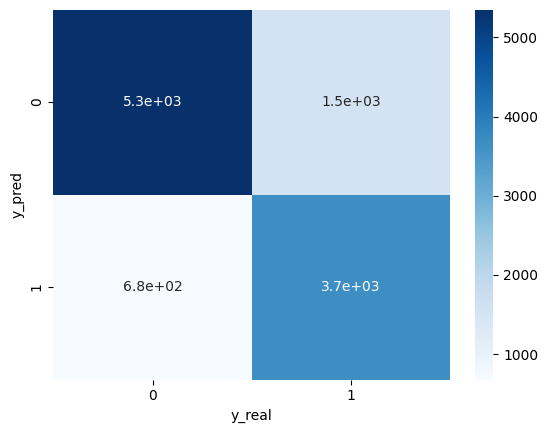

In [48]:
ds_validacion=pd.DataFrame(y_predic_cv,y_test).reset_index()
ds_validacion.columns=['y_pred','y_real']

tabla=pd.crosstab(ds_validacion.y_pred, ds_validacion.y_real)
grf=sns.heatmap(tabla,annot=True, cmap = 'Blues')
plt.show()

In [51]:
best_model = grid_result.best_estimator_.model
loss, accuracy, precision, recall = best_model.evaluate(x_test,y_test)
print(f"Perdida: {loss}")
print(f"Acurracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

y_pred = modelo.predict(x_test)
y_pred = np.round(y_pred).astype(int)
print(f"f1_score: {f1_score(y_test,y_pred)}")

351/351 [==============================] - 0s 962us/step - loss: 0.3999 - accuracy: 0.8028 - precision: 0.7048 - recall: 0.8440
Perdida: 0.3998788297176361
Acurracy: 0.8028143644332886
Precision: 0.7047857046127319
Recall: 0.8439585566520691
351/351 [==============================] - 0s 761us/step
f1_score: 0.5580170808450523


Como se puede observar el f1_score empeoro pero el Acurracy y la precision mejoraron, por ende vamos a usar esta RN para hacer nuestro predict en kaggle.

# Prediccion de kaggle de la red neuronal

In [52]:
ds_hotels_test = pd.read_csv("./hotels_test.csv")
ds_h_test = ds_hotels_test.copy()
ds_h_test.drop(columns="reservation_status_date", inplace=True)
ds_h_test.drop(columns= 'company', inplace = True)

#One hot encoding para variables categoricas
var_cual = ["hotel", "arrival_date_month", "meal", "country", "market_segment", 
"distribution_channel", "reserved_room_type", "assigned_room_type", "deposit_type", "agent", 
"customer_type"]
ds_h_test = pd.get_dummies(ds_h_test, columns=var_cual, drop_first=True)

# Agarramos las columnas diferentes de ds
diff_cols_df2 = set(ds.columns) - set(ds_h_test.columns)

# Agrego las columnas faltantes en ds_h_test y las inicializo en false
for col in diff_cols_df2:
    ds_h_test[col] = np.False_

# Solo me quedo con las columnas de ds_h_test que esten en ds
df_test = ds_h_test[ds.columns]

ds_kag = df_test.drop(["is_canceled"], axis="columns", inplace=True)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
pipeline = Pipeline([  ('imputer', imputer)])
pipeline.fit(ds)

# Obtener lista de columnas de ds
cols_ds = ds.columns

# Seleccionar solo las columnas presentes en ds en ds_h_test
cols_ds_h_test = [col for col in df_test.columns if col in cols_ds]

# Aplicar pipeline solo a las columnas presentes en ambos dataframes
pipeline.fit(ds[cols_ds_h_test])
df_test[cols_ds_h_test] = pipeline.transform(df_test[cols_ds_h_test])

y_pred_kaggle_modelo = modelo.predict(df_test)
y_pred_kaggle_modelo = np.round(y_pred_kaggle_modelo).astype(int)

y_pred_kaggle_cv = best_model.predict(df_test)
y_pred_kaggle_cv = np.round(y_pred_kaggle_cv).astype(int)

ds_kaggle = pd.DataFrame({'id': ds_h_test['id'], 'is_canceled': y_pred_kaggle_cv.ravel()})
ds_kaggle_modelo = pd.DataFrame({'id': ds_h_test['id'], 'is_canceled': y_pred_kaggle_modelo.ravel()})
print(ds_kaggle.shape)
ds_kaggle.to_csv('pred_kaggle_keras_cv.csv', index=False)
ds_kaggle.to_csv('pred_kaggle_keras 6.csv', index=False)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_708\1941125722.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  1/830 [..............................] - ETA: 12s

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_708\1941125722.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_708\1941125722.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_708\1941125722.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

830/830 [==============================] - 1s 790us/step
(26535, 2)


### Guardamos la RN

In [55]:
# Guardar el arbol
import joblib
filename = 'RedNeuronalAdam.sav'
joblib.dump(best_model, filename)

['RedNeuronalAdam.sav']

In [15]:
# Guardar el arbol
import joblib
filename = 'RedNeuronalModelo6.sav'
joblib.dump(modelo, filename)

['RedNeuronalModelo1.sav']